# Posterior and Marginal distributions

This notebook is the continuation of `bandwidths.ipynb` notebook, apliying the bw results and the class for get the n-dimentional PDF. 

#### Some considerations: 
1. As **prior** information we will take the cleaned (without NaN or inf values) information from exoplanet.eu, this is the first part of notebook.

2. The PDF from `oiptimal_pdf` class  fulfills the functions of **likelihood** for a certain number of variables in synthetic systems with no-pertutbation, low perturbation and high perturbation. 

3. To get the **marginal** distributions of a variable of interest, we go in the same way that the example marginalization in the notebook `3D.ipynb`.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Data Cleaning

### 1.1 Simulation data   

see the notation according to <a href="https://github.com/saint-germain/population_synthesis/blob/master/README.md ">Readme.md</a> from `Population_synthesis` project.





In [3]:
#========================== Simulation Data ==========================
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None); dn["gia"]=dn.ngi>0 #without pertubtations 
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None); dl["gia"]=dl.ngi>0 #with low pertubtations 
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None); dh["gia"]=dh.ngi>0 #with high pertubtations

In [4]:
#======================= Simulation variables ========================
##Terrestrial: t; giant;g
dnt=dn[~dn["gia"]]; dng=dn[dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]]; dlg=dl[dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]]; dhg=dh[dh["gia"]] # high pertubtations 

x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [5]:
dnt.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
1,1,5.0,2.932894,12.0,17.882769,0.000488,102.431593,0.110,38.977428,1.075269,-0.150160,1.014449e+06,5.464831,0.0,17.882769,0.0,False,-3.311837,0.467296
3,3,8.0,5.740174,9.0,8.166382,0.000163,62.737337,0.150,58.158928,1.076658,-0.282408,6.017040e+06,4.704798,0.0,8.166382,0.0,False,-3.786940,0.758925
5,5,15.0,8.394027,8.0,16.003091,0.000436,106.824759,0.110,38.167542,0.986003,0.388613,2.435406e+06,5.218175,0.0,16.003091,0.0,False,-3.360068,0.923970
6,6,16.0,4.289089,24.0,12.426573,0.000219,118.543720,0.170,45.042137,1.258747,-0.352459,1.107032e+06,4.469478,0.0,12.426573,0.0,False,-3.658976,0.632365
7,7,17.0,3.771156,12.0,16.762554,0.000811,35.587738,0.062,49.645451,0.739731,0.121866,9.050091e+06,7.257983,0.0,16.762554,0.0,False,-3.090930,0.576474


### 1.2 Observational data 

Data get from <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [6]:
data_o = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                       usecols = ['mass','mass_error_min','semi_major_axis','semi_major_axis_error_min','star_name',
                                  'star_metallicity','star_metallicity_error_min','star_mass','star_mass_error_min'])

data_o = data_o.replace([np.inf, -np.inf], np.nan) 
data_o = data_o.replace([0], np.nan)
data_o = data_o.dropna()

In [7]:
data_o = data_o[['star_name','mass','mass_error_min', 'semi_major_axis', 'semi_major_axis_error_min', 
                 'star_metallicity', 'star_metallicity_error_min', 'star_mass', 'star_mass_error_min']]

data_o = data_o.assign(CM_i = data_o["semi_major_axis"]*data_o["mass"])
data_o = data_o.assign(dCM_i= data_o["CM_i"]*(data_o["mass_error_min"].divide(data_o["mass"])+data_o["semi_major_axis_error_min"].divide(data_o["semi_major_axis"])))

In [8]:
number=(data_o["star_name"].value_counts()).to_frame()

In [9]:
def NewData(data):
   
    p_system = data.groupby("star_name")
    
    Mtp   = p_system['mass'].sum();             dMtp   = p_system['mass_error_min'].sum();  
    ms    = p_system['star_mass'].mean();        dms    = p_system['star_mass_error_min'].mean()
    metal = p_system['star_metallicity'].mean(); dmetal = p_system['star_metallicity_error_min'].mean()
    
    
    CoM  = p_system['CM_i'].sum().divide(p_system["mass"].sum())
    dCoM = CoM*((p_system['dCM_i'].sum()/p_system['CM_i'].sum()) + (p_system['mass_error_min'].sum())/p_system['mass'].sum())
    
    NewData = pd.DataFrame({'sys_name':list(p_system.groups.keys()),
                            'Mtp':Mtp, 'dMtp':dMtp,
                            'com':CoM.tolist(), 'dcom':dCoM.tolist(), 
                            'ms':ms, 'dms':dms, 'metal':metal, 'dmetal':dmetal})
    return NewData

In [10]:
obs_data = NewData(data_o)
obs_data = obs_data.assign(n_planets = number)
obs_data = obs_data.sort_values(by=['n_planets'], ascending=False)
obs_data.head()

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
TRAPPIST-1,TRAPPIST-1,0.017701,0.010374,0.029040,0.034407,0.080,0.007,0.04,0.08,7
K2-138,K2-138,0.113900,0.030500,0.083596,0.053756,0.930,0.060,0.16,0.04,6
GJ 876,GJ 876,2.861000,0.045000,0.185302,0.005413,0.334,0.030,0.05,0.20,4
WASP-47,WASP-47,2.511800,0.097400,0.760462,0.220362,1.110,0.490,0.18,0.07,4
Kepler-289,Kepler-289,0.451000,0.077000,0.489512,0.184174,1.080,0.020,0.05,0.04,3


In [11]:
#system_i = data_o[data_o.star_name == "Kepler-289"]  
#system_i

## 2. Posterior probability 

At first example we take the system "Kepler-289" to get the prior information of stellar mass `ms` and its metallicity `metal`, reported in the catalog of <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [12]:
systm = obs_data[obs_data.sys_name == "Kepler-289"] 
systm

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
Kepler-289,Kepler-289,0.451,0.077,0.489512,0.184174,1.08,0.02,0.05,0.04,3


### 2.1 Likelihood

In [13]:
import nbimporter
from bandwidths import optimal_pdf #import the class for get the pdf.

Importing Jupyter notebook from bandwidths.ipynb


In this example we take the variables `dng.ms`, `dng.metal` and `dng.nplanets` 

In [14]:
likelihood = optimal_pdf(dng.ms, dng.metal, dng.nplanets)
likelihood.pdf()

In [15]:
#Lkepler_289 = kepler_289.pdf_std/kepler_289.pdf_std.sum()

### 2.2 Prior infromation



To generate a 2D prior, we multiply a 2D matrix of ones times each prior. Here, we multiply the first prior normaly but for the second prior it is necessary to transpose the previous result. 

$$\text{prior} = ((1_{n\times n}\times Px_n)^{t}\times Py_n)^{t}$$

Finally, we transpose the result to get the prior distribution. For more dimensions the process is the same

In [16]:
from scipy.stats import truncnorm

In [35]:
# per data needs a list with [mu, sigma]: 

class prior(optimal_pdf):
    
    def __init__(self, *args):
        
        self.lenght = 100
        self.org_data = np.array(args)
        
        d = [np.linspace(args[i][0]-3*args[i][1], args[i][0]+3*args[i][1],self.lenght) for i in range(len(args))]
        
        self.prior_data = [np.ravel(d[i]) for i in range(len(d))]
        
        optimal_pdf.__init__(self,*self.prior_data)
        optimal_pdf.grids(self)
        
    def prior_pdf(self):
        
        self.prior_pdfs = [] 
        M_ones = np.ones([self.lenght, self.lenght])     
        minimum = 0
        
        for i in range(len(self.org_data)): 
            
            a = (minimum - self.org_data[i][0]) / self.org_data[i][1] 
            b = (3*self.org_data[i][1]) / self.org_data[i][1] 
            
            pdf = truncnorm.pdf(self.prior_data[i], a, b, scale=self.org_data[i][1], loc=self.org_data[i][0])
            self.prior_pdfs.append(pdf)
            
        if len(self.org_data) == 2:
            
            M_ones = np.ones([self.lenght, self.lenght]) 
            
            prior = ((M_ones*self.prior_pdfs[0]).T*self.prior_pdfs[1]).T     
            #norm  = (prior.sum(axis=0)*(self.data_std[:,0][1]-self.data_std[:,0][0])).sum()*(self.data_std[:,1][1]-self.data_std[:,1][0])
            
            self.prior_pdf = prior#/norm
        
        elif len(self.org_data) == 3: 
            M_ones = np.ones([self.lenght, self.lenght, self.lenght])    
            prior = (((M_ones*self.prior_pdfs[0]).T*self.prior_pdfs[1]).T*self.prior_pdfs[2]).T 
        
        #return self.prior

In [36]:
prior = prior([systm.ms, systm.dms],[systm.metal,systm.dmetal])#,[systm.Mtp,  systm.dMtp])
prior.prior_pdf()

In [37]:
#(prior.prior.sum(axis=0)*(Kepler_289.data_std[:,0][1]-Kepler_289.data_std[:,0][0])).sum()*(Kepler_289.data_std[:,1][1]-Kepler_289.data_std[:,1][0])

In [38]:
#plt.plot(prior.data[:,1],prior.prior_pdfs[1])
#plt.plot(prior.data_std[:,1],prior.prior_pdfs[1])

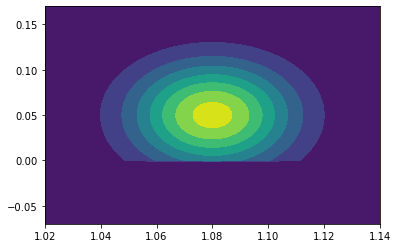

In [39]:
plt.contourf(prior.data[:,0],prior.data[:,1],prior.prior_pdf)
#plt.contourf(prior.data_std[:,0],prior.data_std[:,1],prior.prior_pdf)

### 2.3 Posterior and marginal distributions

#### Posterior

The posterior distribution comes form Bayes Theorem, then:

$$\boxed{\text{Posterior}_{lmn} \propto \text{PDF}_{lnm}\times \text{Prior}_{nm}}$$

Sum the posterior over $l$ is the `axis=0`, $n$ means the `axis=1` and $n$ is the `axis=2`. Finally if we normalize the posterior the above equation becomes into equality.  

So, the posterior is the product of a likelihood with shape $l=100$, $m=100$ and $n=100$ times the prior with shape $m=100$ and $n=100$: 

In [40]:
posterior = likelihood.pdf_std*prior.prior_pdf

But it is necessary to normalize it:  

In [41]:
dx = likelihood.data_std[:,0][1] - likelihood.data_std[:,0][0]
dy = likelihood.data_std[:,1][1] - likelihood.data_std[:,1][0]
dz = likelihood.data_std[:,2][1] - likelihood.data_std[:,2][0]

In [42]:
norm = ((posterior.sum(axis=0)*(dx)).sum(axis=0)*(dy)).sum()*(dz)

In [43]:
post = posterior/norm

In [55]:
#((post.sum(axis=0)*dx).sum(axis=0)*dy).sum()*dz

#### Marginal distriution 

In our example, we take stellar mass, metallicity and number of planets. The likelihood came from giant planets obervations without perturbations in its disk structure. 

We will get the marginal distribution for the number of planets in the system "Kepler-289". 

In [45]:
Np_marginal = (post.sum(axis=0)*dx).sum(axis=0)*dy

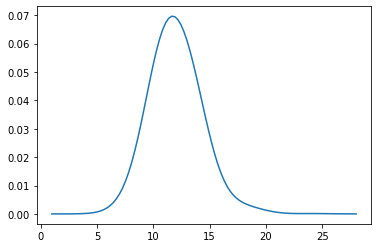

In [46]:
plt.plot(likelihood.real_interval[2], Np_marginal)

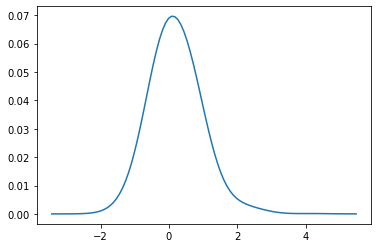

In [48]:
plt.plot(likelihood.std_interval[2], Np_marginal)

with perturbations

In [49]:
likelihood2 = optimal_pdf(dhg.ms, dhg.metal, dhg.nplanets)
likelihood2.pdf()

In [50]:
posterior2 = likelihood2.pdf_std*prior.prior_pdf

In [51]:
dx2 = likelihood2.data_std[:,0][1] - likelihood2.data_std[:,0][0]
dy2 = likelihood2.data_std[:,1][1] - likelihood2.data_std[:,1][0]
dz2 = likelihood2.data_std[:,2][1] - likelihood2.data_std[:,2][0]

In [52]:
Np_marginal = (post.sum(axis=0)*dx).sum(axis=0)*dy

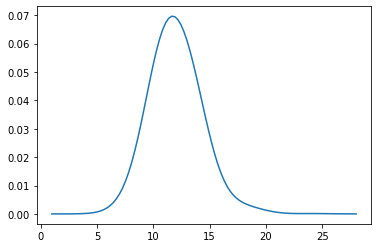

In [53]:
plt.plot(likelihood.real_interval[2], Np_marginal)